In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FPT Historical Data 10 years.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']
df.size

11277

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
len(val_data)

323

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 4s 102ms/step - loss: 0.0051 - val_loss: 0.0510
Epoch 2/100
14/14 [==============================] - 1s 77ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 3/100
14/14 [==============================] - 1s 79ms/step - loss: 3.9880e-04 - val_loss: 0.1342
Epoch 4/100
14/14 [==============================] - 1s 80ms/step - loss: 2.7962e-04 - val_loss: 0.0181
Epoch 5/100
14/14 [==============================] - 1s 80ms/step - loss: 2.0828e-04 - val_loss: 0.0267
Epoch 6/100
14/14 [==============================] - 1s 79ms/step - loss: 1.7274e-04 - val_loss: 0.0210
Epoch 7/100
14/14 [==============================] - 1s 81ms/step - loss: 1.5606e-04 - val_loss: 0.0159
Epoch 8/100
14/14 [==============================] - 1s 82ms/step - loss: 1.5359e-04 - val_loss: 0.0199
Epoch 9/100
14/14 [==============================] - 1s 81ms/step - loss: 1.4368e-04 - val_loss: 0.0077
Epoch 10/100
14/14 [==============================] - 1s 86ms/step - lo

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 17ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [14]:
# 13. Dự báo 30 ngày tiếp theo

# n_steps=100
# x_input=val_data[60:].reshape(1,-1)

n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.83769286]
101
1 day input [0.32489948 0.34114719 0.36218168 0.36986788 0.37238436 0.38633442
 0.3969474  0.4189119  0.41002216 0.39328209 0.42265926 0.45969529
 0.46166471 0.46325118 0.47635329 0.49175306 0.45884734 0.46910473
 0.50756312 0.52851555 0.51185755 0.51155666 0.54120736 0.54208266
 0.54569326 0.5163708  0.53067644 0.56303509 0.55737301 0.53652999
 0.51973522 0.49968544 0.50239339 0.58199075 0.5716513  0.57753221
 0.56973659 0.55556771 0.57241719 0.58817254 0.57898192 0.57170601
 0.59613228 0.57575426 0.56287098 0.56289833 0.59290462 0.59741787
 0.63333242 0.63836538 0.64315216 0.65133073 0.65868869 0.67846495
 0.66719549 0.66041194 0.65710222 0.67280287 0.68371673 0.69449383
 0.6996362  0.68563145 0.6699855  0.67425258 0.68907793 0.67786318
 0.65942723 0.65855193 0.66662108 0.67329522 0.691485   0.6987062
 0.67608523 0.67649553 0.67438934 0.65247955 0.67203698 0.6794223
 0.69372795 0.72548483 0.7063377  0.69517766 0.68861293 0.71919363
 0.73207692 0.71621215 0.72480101 0

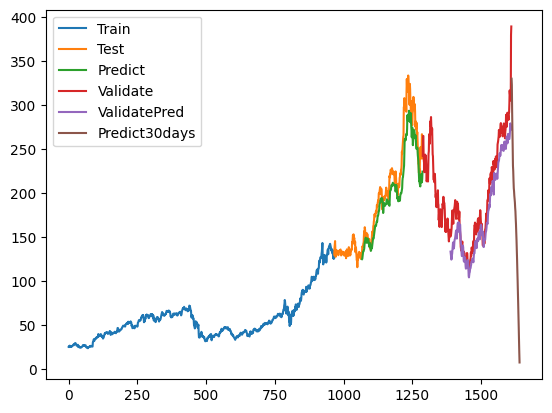

In [15]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_pre_data_index = pd.RangeIndex(start=train_size+n_steps+1, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_pre_data_index = pd.RangeIndex(start=train_size+test_size+n_steps+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Validation RMSE: 183.32895575037293
Testing RMSE: 206.32916867463683


In [17]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[330.12213151 322.86368252 293.85716869 272.70262157 253.10045547
 231.21689505 225.20752006 214.53568506 205.72446281 202.39212791]


In [18]:
print(df['Price'].tail(10))

1601    289.53
1602    292.13
1603    301.78
1604    316.78
1605    312.64
1606    311.76
1607    306.88
1608    305.38
1609    379.80
1610    389.46
Name: Price, dtype: float64


In [19]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_pre_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_pre_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'NVDA CNN_Bi_LSTM data (6:2:2)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [20]:
len(df1)

1611

In [21]:
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)

In [22]:
prediect_data_index

RangeIndex(start=1610, stop=1640, step=1)

In [23]:
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)

In [24]:
prediect_data_index

RangeIndex(start=1611, stop=1641, step=1)

In [25]:
len(val_data)

323

In [26]:
len(df1) - len(train_data) - len(test_data)

323

In [27]:
len(train_data) 

966

In [28]:
test_data_index

RangeIndex(start=966, stop=1288, step=1)

In [29]:
len(train_data) + len(test_data)

1288

In [30]:
val_data_index

RangeIndex(start=1288, stop=1611, step=1)

In [31]:
prediect_data_index

RangeIndex(start=1611, stop=1641, step=1)